# COMPUTER VISION TUTORIAL LAGOS 

In this tutorial we will explore some fundamentals of computer vision, using the MNIST dataset (see lecture).

Some questions and exercies will be provided in this notebook but the reader is highly encouraged to re run all the cells (unless it is specified) and experiment.

First of all, a working version pytorch and torchvision is needed to run all the exercies.

This can can be easily install using pip inside the jupyter notebook

In [96]:
!pip install torchvision
!pip install torchview


[notice] A new release of pip is available: 23.1.2 -> 24.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


Once installed torchvision, let us import some libraries needed for the rest of the notebook

In [97]:
import numpy as np
import pandas as pd

In [98]:
import torch
import torchvision
import torchvision.transforms as transforms
import time

In [99]:
import numpy as np
import matplotlib.pyplot as plt

In [100]:
#this line is needed for a better visualization
%matplotlib inline 

# LOADING DATASET FROM TORCH

As we saw during the main lecture, Pytorch can load and save automatically a large number of datasets.

In particular, we will work with the MNIST dataset a large handwritten digits database commonly used for computer vision.

If you already downloaded the dataset, please input the folder name where the dataset is saved in the **root** option of the dataset command. 

In [156]:
#define transformations that will be applied on the images 
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])

batch_size = 10

#save and load training dataset 
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Let us display the first 10 images of the test dataset.

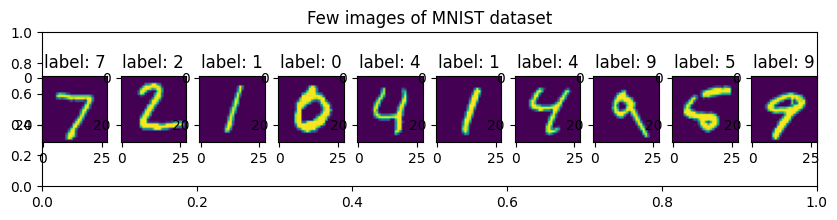

In [157]:
nb_digits_to_display = 10

plt.figure(figsize=(10,2)) 
plt.title("Few images of MNIST dataset")
for i in range(nb_digits_to_display):
    plt.subplot(1,nb_digits_to_display, i+1)
    plt.imshow(testset.data[i].numpy())
    plt.title(f"label: {testset.targets[i].numpy()}")

#plt.suptitle("Few images of MNIST testing dataset", fontsize=16)

Let us do some simple data exploration of this dataset. This is no different of what you have done for the other datasets in this school but it will teach how to handle this simple operation with pytorch, which is based on different way of representing data (namely [tensors](https://pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html)).

### QUESTION 1:
1. What is the number of images in training and testing datasets?

In [158]:
#Solution 1
print("Number of images in training dataset : ", len(trainset))

Number of images in training dataset :  60000


In [159]:
#Solution 1
print("Number of images in test dataset : ", len(testset))

Number of images in test dataset :  10000


### QUESTION 2:
 
2. How are the different classes (number) distributed in the train dataset? Is it similar to test dataset?

### Solution 2
We can easily see how many classes and what their names are with 

In [160]:
# Solution 2
trainset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

Similarly, we can extract the targets list for each dataset by using

In [161]:
trainset.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

As you can see, Jupyter is telling that (as we know by now) that the targets are stored as tensor.
For convience, it is better to convert this target into numpy array using 

In [162]:
train_targets_numpy = trainset.targets.numpy()

Which can be used to plot the frequency histogram of the classes  

Text(0.5, 1.0, 'Class frequency histogram for training dataset')

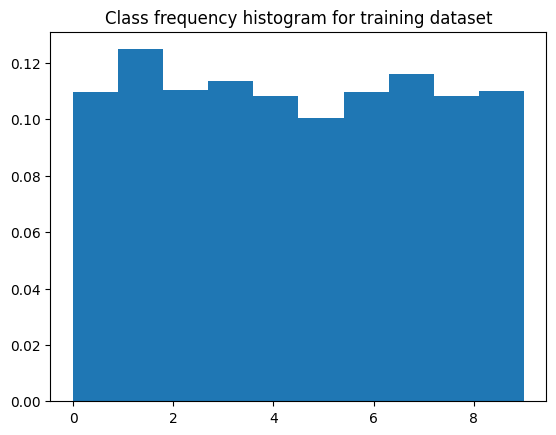

In [165]:
_, _, _ = plt.hist(train_targets_numpy, bins=10, density=True)
plt.title("Class frequency histogram for training dataset")

Text(0.5, 1.0, 'Class frequency histogram for test dataset')

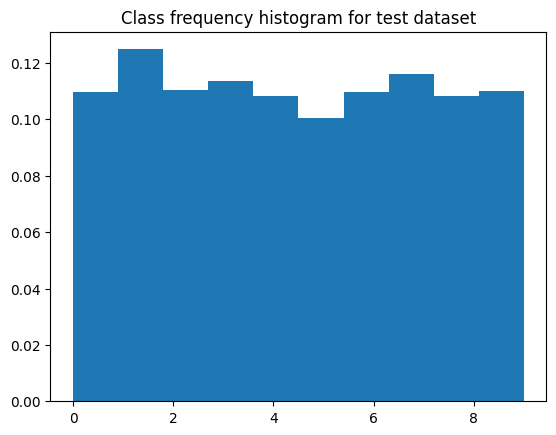

In [34]:
_, _, _ = plt.hist(trainset.targets.numpy(), bins=10, density=True)
plt.title("Class frequency histogram for test dataset")

As expected, classes are well represented in both training and testing dataset

Let us now define the neural network we will use to train the classifier.

### QUESTION 3
3. The following definition contains two mistakes: the user can try to run the following two cells to have a hint on how to make this work or the solution after the training loop. 

In [21]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


net = Net()



### Solution3: 

1. the first convolution does not have the right out_channels to be consistent with the second convolution (16 --> 32)
2. in the forward definition before the pass the input through the two linears operators, the input should be flatten. This can be done by adding x = torch.flatten(x, 1) 

After the user modified correctly the defition of Net() above, we can run the training. 

This might take some time (depending on your machine), so it might be a good idea to take a break :) 

In [45]:
import torch.optim as optim

# let us define the criterion and optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

start = time.time()
running_losses = []
n_loop = 2
step_loss = 200

for epoch in range(n_loop):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % step_loss == step_loss - 1:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / step_loss:.3f}') #comment this line if you do not want to see how running loss evolves in real time
            running_losses.append(running_loss)
            running_loss = 0.0

print('Finished Training')
print('Completed in {} secs'.format(time.time() - start))

[1,   200] loss: 1.218
[1,   400] loss: 0.434
[1,   600] loss: 0.427
[1,   800] loss: 0.301
[1,  1000] loss: 0.323
[1,  1200] loss: 0.246
[1,  1400] loss: 0.217
[1,  1600] loss: 0.196
[1,  1800] loss: 0.200
[1,  2000] loss: 0.179
[1,  2200] loss: 0.162
[1,  2400] loss: 0.128
[1,  2600] loss: 0.141
[1,  2800] loss: 0.126
[1,  3000] loss: 0.109
[1,  3200] loss: 0.125
[1,  3400] loss: 0.104
[1,  3600] loss: 0.086
[1,  3800] loss: 0.095
[1,  4000] loss: 0.119
[1,  4200] loss: 0.085
[1,  4400] loss: 0.120
[1,  4600] loss: 0.090
[1,  4800] loss: 0.078
[1,  5000] loss: 0.065
[1,  5200] loss: 0.085
[1,  5400] loss: 0.063
[1,  5600] loss: 0.073
[1,  5800] loss: 0.074
[1,  6000] loss: 0.076
[2,   200] loss: 0.065
[2,   400] loss: 0.059
[2,   600] loss: 0.059
[2,   800] loss: 0.048
[2,  1000] loss: 0.059
[2,  1200] loss: 0.059
[2,  1400] loss: 0.055
[2,  1600] loss: 0.074
[2,  1800] loss: 0.062
[2,  2000] loss: 0.060
[2,  2200] loss: 0.063
[2,  2400] loss: 0.055
[2,  2600] loss: 0.054
[2,  2800] 

# ANALYSIS OF THE RESULTS

Once the traning is completed, we can visualize the evolution of the running loss:

Text(0.5, 0, 'Number of steps')

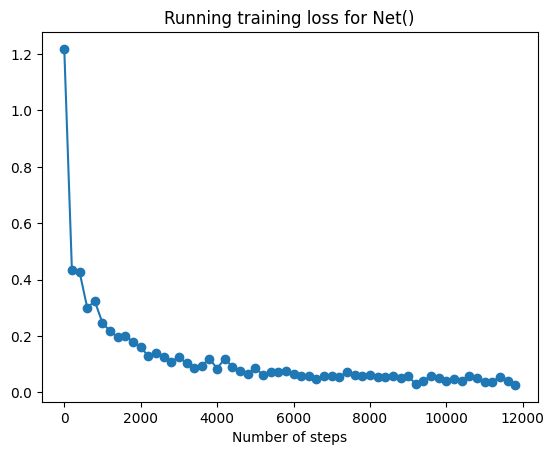

In [47]:
running_losses = np.array(running_losses) / step_loss
training_steps = np.arange(0, n_loop*len(trainset) // batch_size, step_loss) 
plt.plot(training_steps, running_losses, 'o-')
plt.title("Running training loss for Net()")
plt.xlabel("Number of steps")

### Question 4

4. According to the plot above, it is reasonable to ask:

    1. Was is it worthy to have a second loop over the dataset?
    2. Would it be a good idea to have a 3rd or 4th loop?

### Solution4:

    1. Yes, as one can see the running loss decreases of approximately 5 % after step 6000 (first loop)
    2. Probably not, the running is pratically stable after the 10000th iteration, so there is no indication that more loops would help.

Let us know save the model for future use:

In [55]:
PATH = './my_minst_model_net.pth'
torch.save(net, PATH)

#the model can be loaded with the following command
#model_saved = torch.load(PATH)

In [56]:
PATH = './my_minst_model_net.pth'
model_saved = torch.load(PATH)

In the next cells, the results for the testing set and the confusion matrix will be computed.

The reader is highly encoured to carefully read these cells and trying to modify some cells to get a better understanding of the results.
In particular, some short questions and remarks are highligheted in the cells to help the reader navigate the code:

In [106]:
import pandas as pd
import torch.nn.functional as F
# Test function 
def testing_accuracy(model, data_loader):
    model.eval()
    test_loss = 0
    device = 'cpu'

    y_pred = []
    y_actu = []
    with torch.no_grad(): #why no_grad here? https://www.geeksforgeeks.org/what-is-with-torch-no_grad-in-pytorch/ (OPTIONAL)
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data) #computing output on test dataset (in batches)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            y_pred.extend(torch.flatten(pred).tolist()) #compute prediction on the whole test dataset
            y_actu.extend(target.tolist())
           
    y_pred = pd.Series(y_pred, name='Actual') 
    y_actu = pd.Series(y_actu, name='Predicted')
    #pd.crosstab computes the cross tabulation of two arrays (pandas series), it is a neat trick to compute the confusion matrix 
    cm = pd.crosstab(y_actu, y_pred)
    correct = sum([cm.iloc[i,i] for i in range(len(cm))])
    
    test_loss /= len(data_loader.dataset)
    accuracy = 100*correct/len(y_pred)
    
    return test_loss, accuracy, cm, y_pred, y_actu


In [61]:
test_results_net  = testing_accuracy(model_saved, testloader)

print("- Test Loss: ", test_results_net[0], "\n")
print("- Accuracy: ", test_results_net[1], "\n")
print("- Confusion Matrix: \n \n",  test_results_net[2] )

y_pred 0       7
1       2
2       1
3       0
4       4
       ..
9995    2
9996    3
9997    4
9998    5
9999    6
Name: Actual, Length: 10000, dtype: int64
0.0007
- Test Loss:  0.03637099148133421 

- Accuracy:  98.74 

- Confusion Matrix: 
 
 Actual       0     1     2    3    4    5    6     7    8    9
Predicted                                                     
0          976     0     1    0    0    0    1     1    1    0
1            0  1130     1    0    0    0    2     2    0    0
2            2     3  1010    0    2    0    0    10    4    1
3            0     0     0  995    0    5    0     6    2    2
4            0     0     1    0  972    0    0     2    2    5
5            2     0     0    2    0  884    2     1    0    1
6            6     2     0    0    2    3  944     0    1    0
7            0     0     4    0    0    0    0  1022    1    1
8            5     0     1    0    1    1    0     7  954    5
9            0     3     0    0    5    2    0    12    0  9

### Question 5
5. The confusion matrix can be also computed easily via [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). The reader is encouraged to reproduce the results in this notebook.

### Solution 5

In [62]:
from sklearn.metrics import confusion_matrix

conf_matrix_sklearn = confusion_matrix(y_actu,y_pred)

Text(0.5, 1.0, 'Confusion Matrix for custom model (ACC = 98.45)')

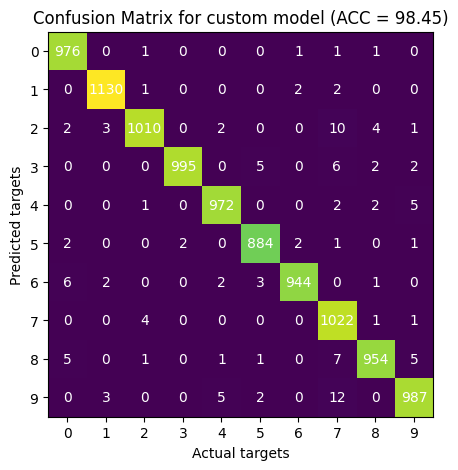

In [126]:
import numpy as np
import matplotlib.pyplot as plt

conf_matrix_net = test_results_net[2].to_numpy()

fig, ax = plt.subplots(figsize=(10,5))
im = ax.imshow(conf_matrix_net)

ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))

for i in range(conf_matrix_net.shape[0]):
    for j in range(conf_matrix_net.shape[1]):
        text = ax.text(j, i, conf_matrix_net[i, j],
                       ha="center", va="center", color="w")
        
ax.set_xlabel('Actual targets')
ax.set_ylabel('Predicted targets')
ax.set_title('Confusion Matrix for custom model (ACC = 98.45)')

# FINE TUNING OF TRAINED MODEL (RESNET50)

In this section we load and fine tune a model from the Pytorch library, namely [ResNet50](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html). 


This can be done using the [models](https://pytorch.org/vision/stable/models.html) library of Pytoch, which we import here. 

In [14]:
from torchvision import  models

resnet =  models.resnet50(weights=True) #this might take some time (unless you already saved it), take  a break :) 

ResNet was originally implemented for a classification problem with 50 classes for images with a  different size of those contained in MNIST.

For this reason, as we saw in the main lecture, we need to modify the first and last layer.

This can be done easily with the Pytorch, using its layer-logic:

### QUESTION 6

6. The following code contains a small mistake, the reader is encouraged to spot it before running the fine tuning script below

In [46]:
def change_layers(model):
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.fc = nn.Linear(2048, 10, bias=True)
    return model

resnet = change_layers(resnet)

### SOLUTION 6

Solution: the number of classes in the final layer is wrong (9 instead of 10)

Let us now fine tune (see lectures) ResNet for MNINST: 

**IMPORTANT: THIS TRANING WILL BE MUCH LONGER THAN THE PREVIOUS ONE, THEREFORE THE READER SHOULD FEEL FREE TO SKIP IT AND LOAD THE MODEL IN THE FOLLOWING CELL** 

In [48]:
#FINE TUNING

start = time.time()

optimizer_resnet = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

n_loop = 2
step_loss = 200
running_losses_resnet = []

for epoch in range(n_loop):  # loop over the dataset multiple times 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer_resnet.zero_grad()

        # forward + backward + optimize
        outputs = resnet(inputs)
        loss_resnet = criterion(outputs, labels)
        loss_resnet.backward()
        optimizer_resnet.step()

        # print statistics
        running_loss += loss_resnet.item()
        if i % step_loss == step_loss - 1:    # print every step_loss 
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / step_loss:.3f}')
            running_losses_resnet.append(running_loss)
            running_loss = 0.0

print('Finished Training')
print('Completed in {} secs'.format(time.time() - start))

[1,   200] loss: 1.460
[1,   400] loss: 0.708
[1,   600] loss: 0.505
[1,   800] loss: 0.391
[1,  1000] loss: 0.345
[1,  1200] loss: 0.280
[1,  1400] loss: 0.248
[1,  1600] loss: 0.250
[1,  1800] loss: 0.201
[1,  2000] loss: 0.166
[1,  2200] loss: 0.195
[1,  2400] loss: 0.155
[1,  2600] loss: 0.179
[1,  2800] loss: 0.175
[1,  3000] loss: 0.167
[1,  3200] loss: 0.116
[1,  3400] loss: 0.127
[1,  3600] loss: 0.133
[1,  3800] loss: 0.129
[1,  4000] loss: 0.108
[1,  4200] loss: 0.129
[1,  4400] loss: 0.117
[1,  4600] loss: 0.117
[1,  4800] loss: 0.073
[1,  5000] loss: 0.082
[1,  5200] loss: 0.113
[1,  5400] loss: 0.094
[1,  5600] loss: 0.083
[1,  5800] loss: 0.097
[1,  6000] loss: 0.092
[2,   200] loss: 0.090
[2,   400] loss: 0.077
[2,   600] loss: 0.089
[2,   800] loss: 0.085
[2,  1000] loss: 0.073
[2,  1200] loss: 0.081
[2,  1400] loss: 0.065
[2,  1600] loss: 0.070
[2,  1800] loss: 0.063
[2,  2000] loss: 0.083
[2,  2200] loss: 0.072
[2,  2400] loss: 0.065
[2,  2600] loss: 0.054
[2,  2800] 

In [88]:
#PATH_RES = './my_resnet_mnsit.pth'

#torch.save(resnet, PATH_RES)

#np.save('running_losses_resnet.npy', running_losses_resnet)

In [ ]:
The reader can learn trained ResNet model and the corresponding running training curve using:

In [89]:
running_losses_resnet = np.load('running_losses_resnet.npy')
resnet_loaded = torch.load(PATH_RES)

Let us now visualize the loss curve for ResNet (and Net()) :

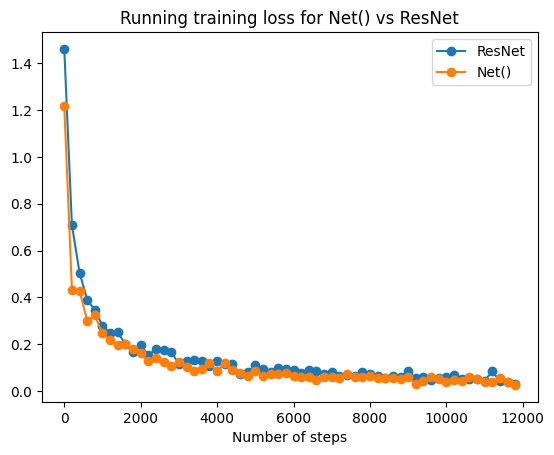

In [90]:
running_losses_resnet = np.array(running_losses_resnet) / step_loss
training_steps = np.arange(0, n_loop*len(trainset) // batch_size, step_loss) 
plt.plot(training_steps, running_losses_resnet, 'o-', label="ResNet")
plt.plot(training_steps, running_losses, 'o-', label="Net()")
plt.title("Running training loss for Net() vs ResNet")
plt.xlabel("Number of steps")
plt.legend()

It is worthy here to ask similar questions to the ones we asked for Net() for ResNet():

    1. Was is it worthy to have a second loop over the dataset?
    2. Would it be a good idea to have a 3rd or 4th loop?

And the answers are similar.

However it is worth noticing the ResNet() seems to require less steps than Net() to become stable so we might have stopped this training before. 

For more information on how we stop the training, the reader is encouraged to read [Early stopping](https://machinelearningmastery.com/early-stopping-to-avoid-overtraining-neural-network-models/). 


Finally, let us compute the confusion matrix for Resnet:

In [95]:
test_results_resnet = testing_accuracy(resnet_loaded, testloader)

print("- Test Loss: ", test_results_resnet[0], "\n")
print("- Accuracy: ", test_results_resnet[1], "\n")
print("- Confusion Matrix: \n \n",  test_results_resnet[2] )

- Test Loss:  -10.798839831542969 

- Accuracy:  99.13 

- Confusion Matrix: 
 
 Actual       0     1     2     3    4    5    6     7    8    9
Predicted                                                      
0          967     0     3     1    1    2    4     1    0    1
1            0  1134     1     0    0    0    0     0    0    0
2            0     3  1025     0    1    0    0     2    1    0
3            0     1     0  1008    0    1    0     0    0    0
4            0     0     1     0  974    0    3     0    0    4
5            1     0     0     9    0  880    1     0    1    0
6            2     2     0     0    0    1  953     0    0    0
7            0     4     2     2    0    0    0  1017    1    2
8            0     0     1     2    0    1    0     2  965    3
9            0     4     1     3    5    0    0     5    1  990


Text(0.5, 1.0, 'Confusion Matrix for custom model (ACC = 99.99)')

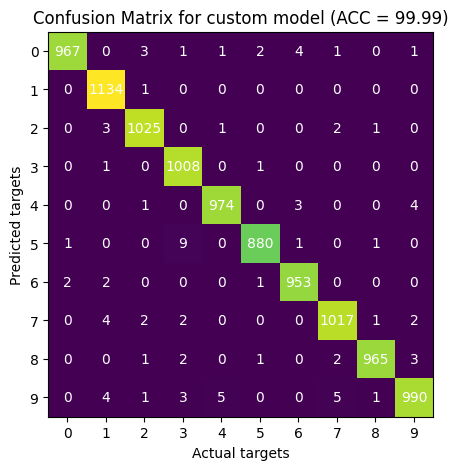

In [125]:
import numpy as np
import matplotlib.pyplot as plt

conf_matrix_resnet = test_results_resnet[2].to_numpy()

fig, ax = plt.subplots(figsize=(10,5))
im = ax.imshow(conf_matrix)

ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))

for i in range(conf_matrix_resnet.shape[0]):
    for j in range(conf_matrix_resnet.shape[1]):
        text = ax.text(j, i, conf_matrix[i, j],
                       ha="center", va="center", color="w")
        
ax.set_xlabel('Actual targets')
ax.set_ylabel('Predicted targets')
ax.set_title('Confusion Matrix for custom model (ACC = 99.99)')

As we can see, ResNet achieves slightly better results but it requires much more running time and computational power. 

### Question 7

For which classes ResNet performs better than Net and viceversa?

### Solution

This question can be answered by evaluating and visualazing the accuracy per class for both Net() and ResNet.

One way of achieving that is:

In [127]:
acc_per_class_resnet = conf_matrix_resnet.diagonal()/conf_matrix_resnet.sum(axis=1)

In [146]:
acc_per_class_net = conf_matrix_net.diagonal()/conf_matrix_net.sum(axis=1)

(0.95, 1.0001)

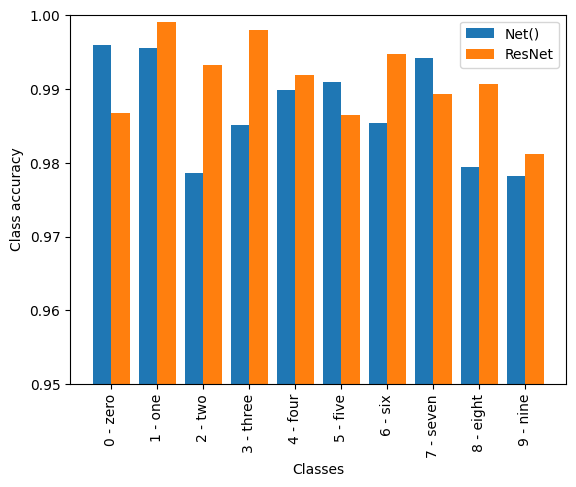

In [173]:
X = trainset.classes 

X_axis = np.arange(len(X)) 
  
plt.bar(X_axis - 0.2, acc_per_class_net, 0.4, label = 'Net()') 
plt.bar(X_axis + 0.2, acc_per_class_resnet, 0.4, label = 'ResNet') 

plt.xticks(X_axis, X) 
plt.xlabel("Classes") 
plt.ylabel("Class accuracy") 
plt.legend()

plt.xticks(rotation=90)
plt.ylim(0.95, 1.0001)

As we can see, for classes 2, 3,  6, 8 and 9 ResNet seems to do a better job, while Net is doing a better a job on class 0.

It is worth noticing here that this differences are pretty small and it is impossible to understand if they have a sound statistical value, especially since we have only run each model once.

This is a common theme for all ML projects, for which it might be computationally expensive to compute confidence intervals (e.g. error bars) on the predictions (see [confidence intervals for machine learning](https://machinelearningmastery.com/confidence-intervals-for-machine-learning/) .

# CONCLUSIONS (WIP)

There is no single way to understand which model one should use for their specific case because this depends on the application, in particular on the baseline (see lecture) and time/computational power available.